# Scatter plots

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
results = xr.open_dataset('/home/koenr/thesis_code/results_2022_ws_gcshifted_mesohourly15pdt_gc_pangu_ERA5_ens_rain_wd.nc')

### Scatter plot function

In [3]:
def create_scatter_plot(
    dataset,
    variable,
    models,
    prediction_timedelta=None,
    stations=None,
    times=None,
    figsize=(10, 6),
    savefig=False,
    filename='scatter_plot.png'
):
    """
    Create scatter plots of forecast data against observation data.

    Parameters:
    - dataset: xarray.Dataset containing the data.
    - variable: str, the variable to plot (e.g., '2m_temperature')
    - models: list of str, models to plot (e.g., ['hres', 'pangu'])
    - prediction_timedelta: list or single value, forecast lead times to select, or None for all
    - stations: list or single value, stations to select, or None for all
    - times: list or single value, initialization times to select, or None for all
    - figsize: tuple, figure size for the plot
    - savefig: bool, whether to save the figure
    - filename: str, filename to save the figure if savefig is True
    """

    # Mapping variables to units
    variable_units = {
        '2m_temperature': '°C',
        'mean_sea_level_pressure': 'hPa',
        '10m_wind_speed': 'm/s',
        '10m_v_component_of_wind': 'm/s',
        '10m_u_component_of_wind': 'm/s',
        'total_precipitation_6hr': 'mm'
    }

    # Create a copy of the dataset to avoid modifying the original
    ds = dataset.copy()

    # Select the desired prediction_timedelta
    if prediction_timedelta is not None:
        ds = ds.sel(prediction_timedelta=prediction_timedelta)

    # Select the desired stations
    if stations is not None:
        ds = ds.sel(station=stations)

    # Select the desired times
    if times is not None:
        ds = ds.sel(time=times)

    # Observation variable
    obs_var_name = f"{variable}_synop"
    if obs_var_name not in ds:
        raise ValueError(f"Observation variable '{obs_var_name}' not found in dataset.")

    obs_data = ds[obs_var_name]

    # Convert observation data to pandas DataFrame
    obs_df = obs_data.to_dataframe(name='Observation').reset_index()

    # Initialize DataFrame with observation data
    data_df = obs_df

    # Loop over models
    for model in models:
        model_var_name = f"{variable}_{model}"
        if model_var_name not in ds:
            print(f"Model variable '{model_var_name}' not found in dataset. Skipping model '{model}'.")
            continue

        model_data = ds[model_var_name]

        # Convert model data to DataFrame
        model_df = model_data.to_dataframe(name=model).reset_index()

        # Merge with observation data
        data_df = pd.merge(
            data_df,
            model_df,
            on=['time', 'prediction_timedelta', 'station'],
            how='inner'
        )

    if data_df.empty:
        raise ValueError("No data available after merging. Check your selections.")

    # Melt the DataFrame for plotting
    melted_df = pd.melt(
        data_df,
        id_vars=['Observation'],
        value_vars=models,
        var_name='Model',
        value_name='Forecast'
    )

    # Remove NaN values
    melted_df = melted_df.dropna(subset=['Observation', 'Forecast'])

    if melted_df.empty:
        raise ValueError("No data available after dropping NaNs. Check your data for missing values.")

    # Get the unit for the selected variable
    unit = variable_units.get(variable, '')

    # Plotting using seaborn
    plt.figure(figsize=figsize)
    sns.scatterplot(data=melted_df, x='Observation', y='Forecast', hue='Model', alpha=0.7)

    # Plot a reference line y = x
    min_val = min(melted_df['Observation'].min(), melted_df['Forecast'].min())
    max_val = max(melted_df['Observation'].max(), melted_df['Forecast'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

    plt.xlabel(f'Observations ({unit})')
    plt.ylabel(f'Forecasts ({unit})')
    plt.title(f"Scatter plot of {variable.replace('_', ' ').capitalize()}")
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()

    if savefig:
        plt.savefig(filename, dpi=300)

    plt.show()


### Density plot function

In [4]:
def create_density_plot(
    dataset,
    variable,
    models,
    prediction_timedelta=None,
    stations=None,
    times=None,
    figsize=(8, 6),
    density_gridsize =200,
    savefig=False,
    filename='density_plot.png'
):
    """
    Create density plots of forecast data against observation data,
    including RMSE, MAE, Bias, and the linear least squares fit equation.

    Parameters:
    - dataset: xarray.Dataset containing the data.
    - variable: str, the variable to plot (e.g., '2m_temperature')
    - models: list of str, models to plot (e.g., ['hres', 'pangu'])
    - prediction_timedelta: list or single value, forecast lead times to select, or None for all
    - stations: list or single value, stations to select, or None for all
    - times: list or single value, initialization times to select, or None for all
    - figsize: tuple, figure size for the plot
    - savefig: bool, whether to save the figure
    - filename: str, filename to save the figure if savefig is True
    """
    # Mapping variables to units
    variable_units = {
        '2m_temperature': '°C',
        'mean_sea_level_pressure': 'hPa',
        '10m_wind_speed': 'm/s',
        '10m_v_component_of_wind': 'm/s',
        '10m_u_component_of_wind': 'm/s',
        'total_precipitation_6hr': 'mm'
    }

    # Create a copy of the dataset to avoid modifying the original
    ds = dataset.copy()

    # Select the desired prediction_timedelta
    if prediction_timedelta is not None:
        ds = ds.sel(prediction_timedelta=prediction_timedelta)

    # Select the desired stations
    if stations is not None:
        ds = ds.sel(station=stations)

    # Select the desired times
    if times is not None:
        ds = ds.sel(time=times)

    # Observation variable
    obs_var_name = f"{variable}_synop"
    if obs_var_name not in ds:
        raise ValueError(f"Observation variable '{obs_var_name}' not found in dataset.")

    obs_data = ds[obs_var_name]

    # Convert observation data to pandas DataFrame
    obs_df = obs_data.to_dataframe(name='Observation').reset_index()

    # Initialize DataFrame with observation data
    data_df = obs_df

    # Loop over models
    for model in models:
        model_var_name = f"{variable}_{model}"
        if model_var_name not in ds:
            print(f"Model variable '{model_var_name}' not found in dataset. Skipping model '{model}'.")
            continue

        model_data = ds[model_var_name]

        # Convert model data to DataFrame
        model_df = model_data.to_dataframe(name='Forecast').reset_index()

        # Add a column for the model
        model_df['Model'] = model

        # Merge with observation data
        merged_df = pd.merge(
            data_df,
            model_df,
            on=['time', 'prediction_timedelta', 'station'],
            how='inner'
        )

        if merged_df.empty:
            print(f"No data available after merging for model '{model}'. Skipping.")
            continue

        # Remove NaN values
        merged_df = merged_df.dropna(subset=['Observation', 'Forecast'])

        if merged_df.empty:
            print(f"No data available after dropping NaNs for model '{model}'. Skipping.")
            continue

        # Get the unit for the selected variable
        unit = variable_units.get(variable, '')

        # Plotting
        plt.figure(figsize=figsize)
        hb = plt.hexbin(
            merged_df['Observation'],
            merged_df['Forecast'],
            gridsize=density_gridsize,
            cmap='inferno',
            mincnt=1
        )

        # Plot a reference line y = x
        min_val = min(merged_df['Observation'].min(), merged_df['Forecast'].min())
        max_val = max(merged_df['Observation'].max(), merged_df['Forecast'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='y = x')

        # Calculate linear least squares fit
        slope, intercept = np.polyfit(merged_df['Observation'], merged_df['Forecast'], 1)
        x_vals = np.array([min_val, max_val])
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, 'k-', lw=2, label='Least Squares Fit')

        # Calculate error metrics
        errors = merged_df['Forecast'] - merged_df['Observation']
        bias = errors.mean()
        mae = errors.abs().mean()
        rmse = np.sqrt((errors ** 2).mean())

        # Create a text box with error metrics and fit equation
        textstr = '\n'.join((
            f'RMSE: {rmse:.2f} {unit}',
            f'MAE: {mae:.2f} {unit}',
            f'Bias: {bias:.2f} {unit}',
            f'y = {slope:.2f} x + {intercept:.2f}'
        ))

        # Place the text box in upper left in axes coords
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=props)

        plt.xlabel(f'Observations ({unit})')
        plt.ylabel(f'Forecasts ({unit})')
        plt.title(f"Density Plot of {variable.replace('_', ' ').capitalize()} - Model: {model}")
        # Removed the colorbar
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if savefig:
            model_filename = filename.replace('.png', f'_{model}.png')
            plt.savefig(model_filename, dpi=300)
            plt.close()
        plt.show()


### Plot Creation

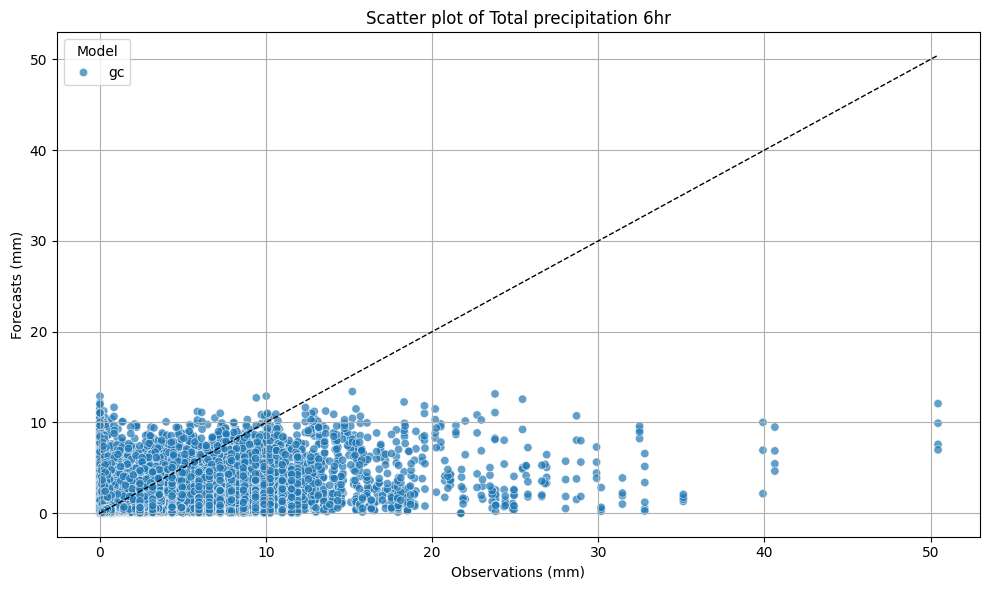

In [60]:
# Variables to consider
variables = [
    '2m_temperature',
    'mean_sea_level_pressure',
    '10m_wind_speed',
    '10m_v_component_of_wind',
    '10m_u_component_of_wind',
    'total_precipitation_6hr'
]

# Model suffixes
model_suffixes = ['meso_pangu_ens', 'analysis', 'meso_gc_ens', 'hres_pangu_ens', 'hres', 'pangu', 'meso', 'gc', 'meso_hres_ens', 'pangu_gc_ens', 'ens', 'ERA5', 'hres_gc_ens']

# Select the variable and models
variable = 'total_precipitation_6hr'
models = ['gc']

# Call the function
create_scatter_plot(
    dataset=results,
    variable=variable,
    models=models,
)


In [61]:
# Variables to consider
variables = [
    '2m_temperature',
    'mean_sea_level_pressure',
    '10m_wind_speed',
    '10m_v_component_of_wind',
    '10m_u_component_of_wind',
    'total_precipitation_6hr'
]

# Model suffixes
model_suffixes = ['meso_pangu_ens', 'analysis', 'meso_gc_ens', 'hres_pangu_ens', 'hres', 'pangu', 'meso', 'gc', 'meso_hres_ens', 'pangu_gc_ens', 'ens', 'ERA5', 'hres_gc_ens']

# # Select the variable and models
# variable = '10m_wind_speed'
# models = ['hres', 'gc', 'ens']

# # Optional selections
# prediction_timedelta = ['6 hours', '12 hours']  # Replace with actual timedelta values
# stations = ['06201', '06380']
# times = pd.date_range('2022-01-12', '2022-01-15', freq='D')



for variable in variables:
    save_path = f'scatter_plots/scatter_{variable}.png'
    create_density_plot(
        results,
        variable=variable,
        models=model_suffixes,
        savefig=True,
        filename=save_path
    )

No data available after dropping NaNs for model 'meso_pangu_ens'. Skipping.
No data available after dropping NaNs for model 'analysis'. Skipping.
No data available after dropping NaNs for model 'hres_pangu_ens'. Skipping.
No data available after dropping NaNs for model 'pangu'. Skipping.
No data available after dropping NaNs for model 'pangu_gc_ens'. Skipping.
No data available after dropping NaNs for model 'ens'. Skipping.


Day


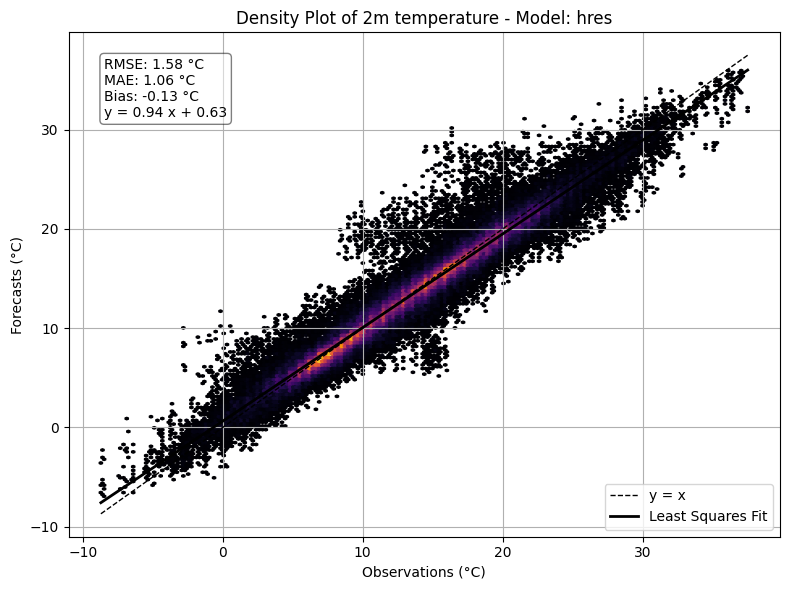

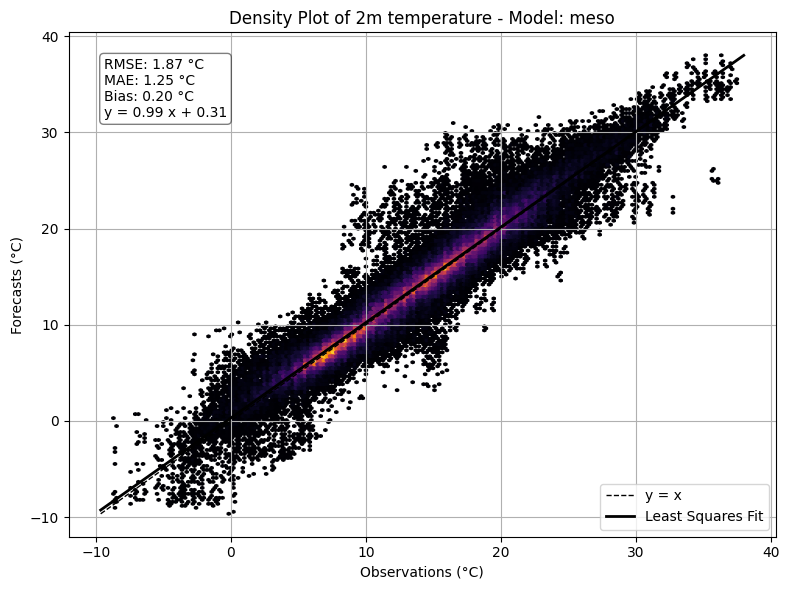

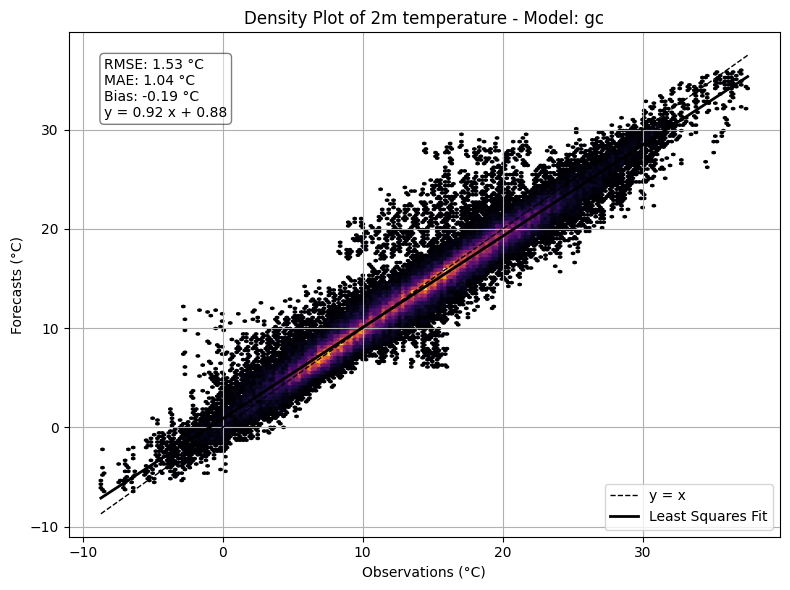

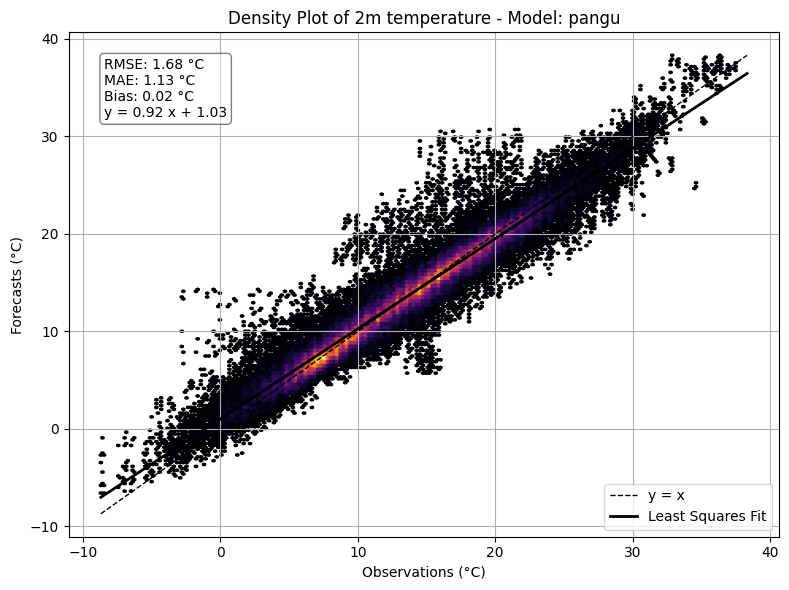

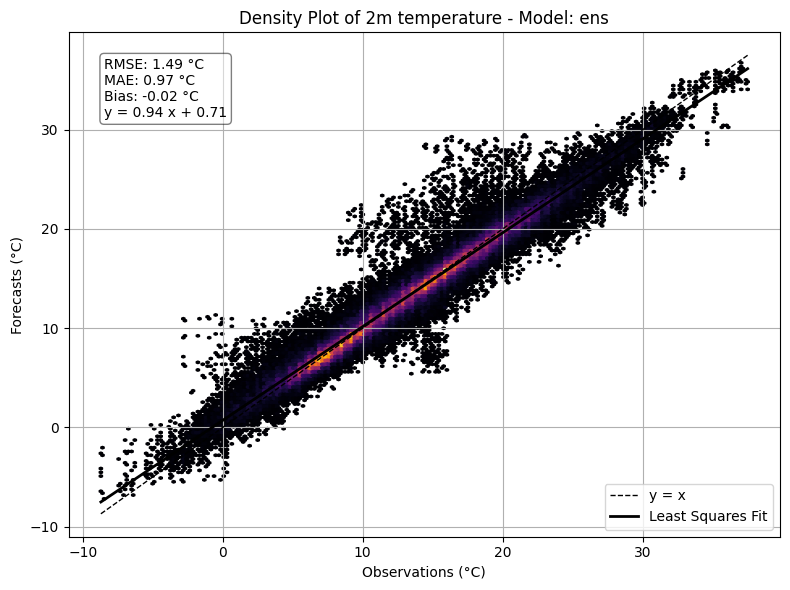

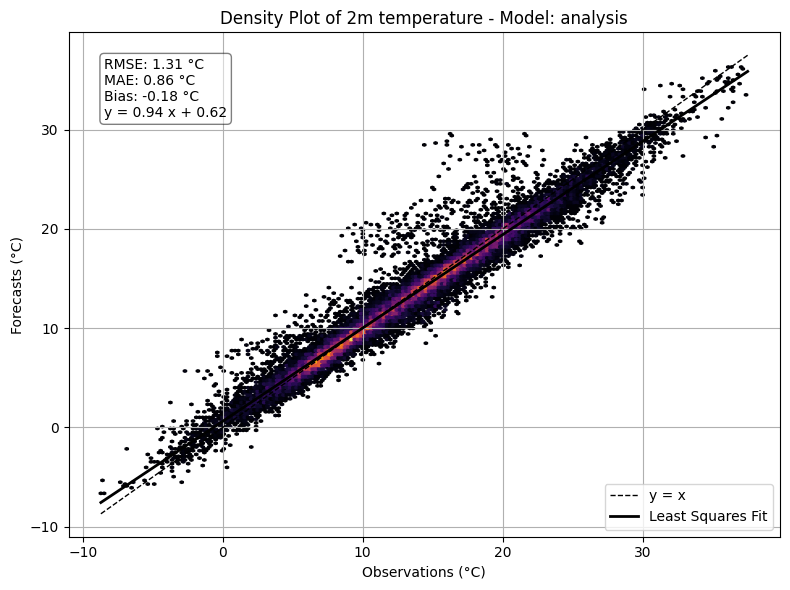

Night


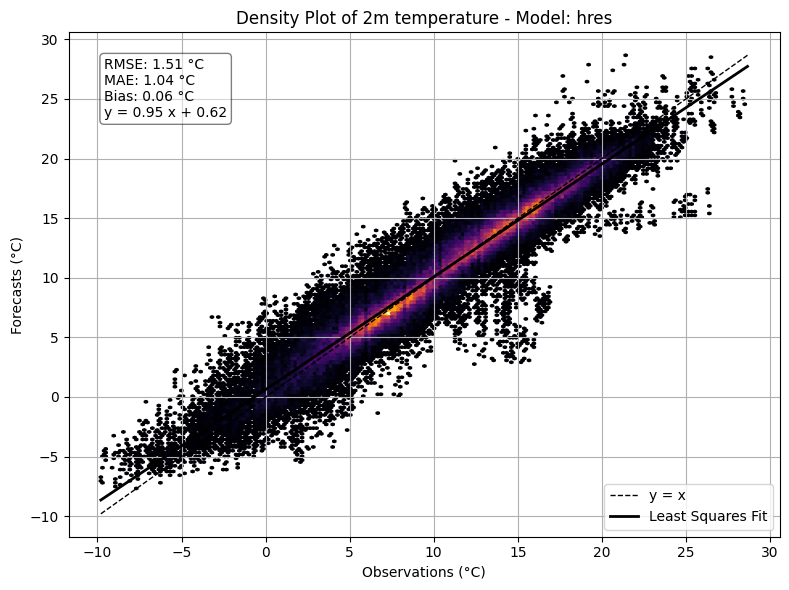

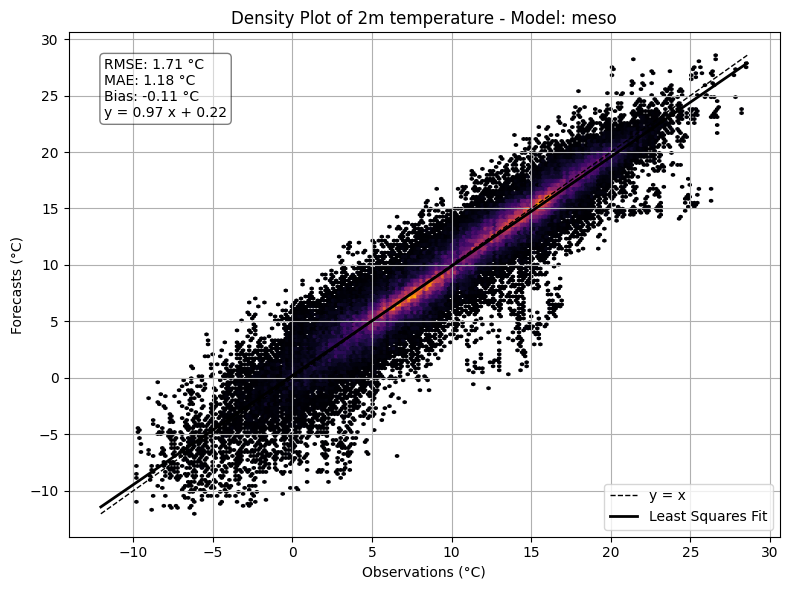

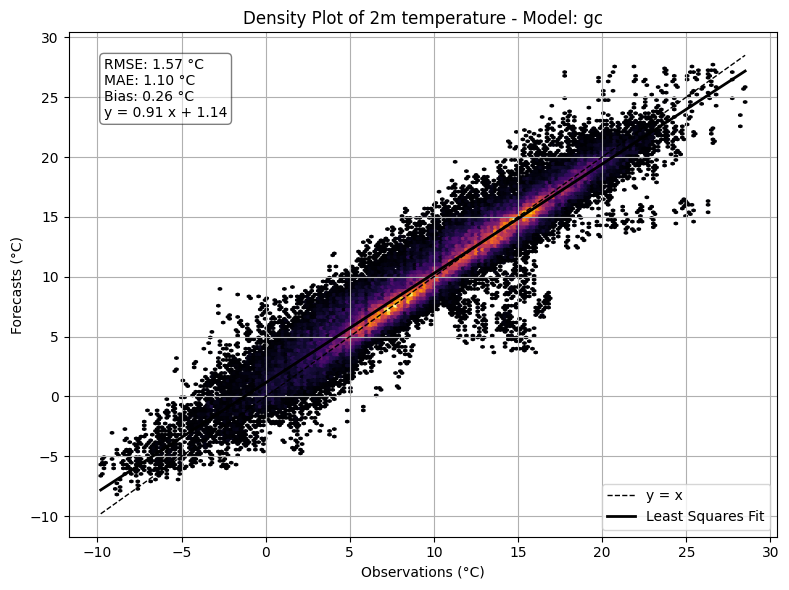

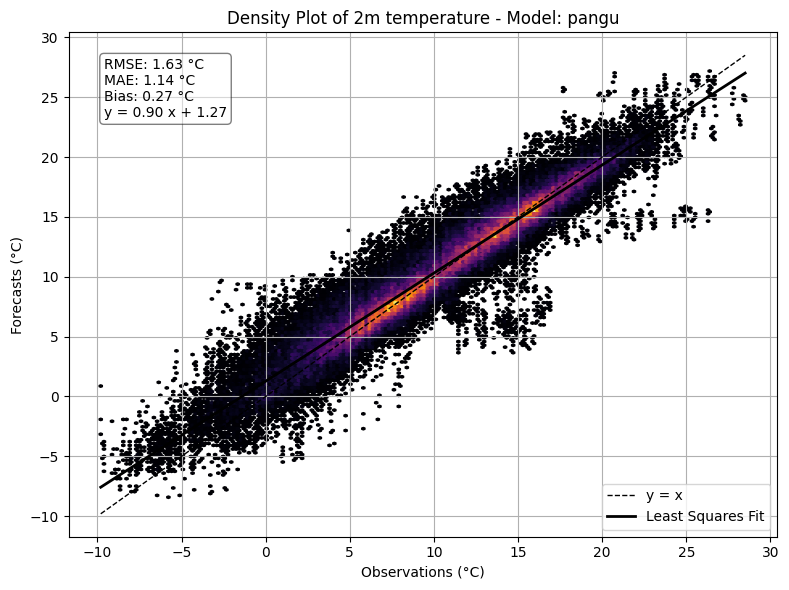

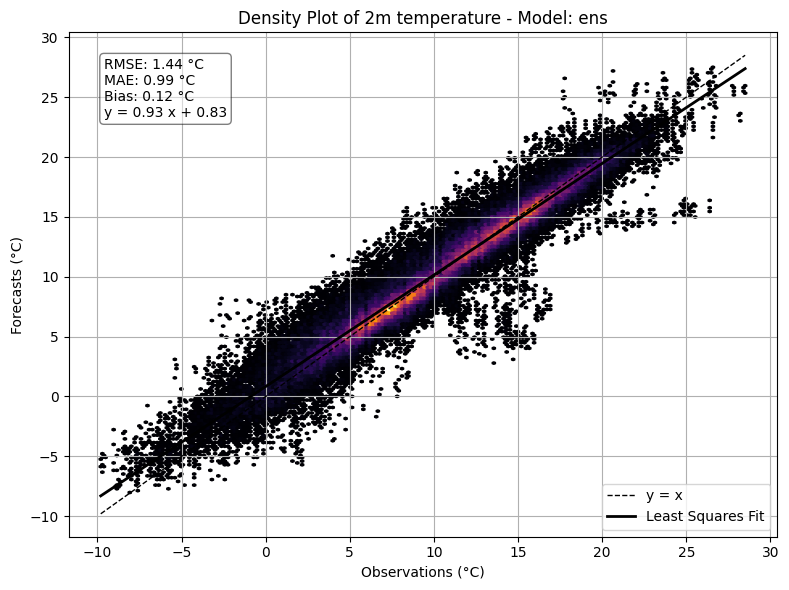

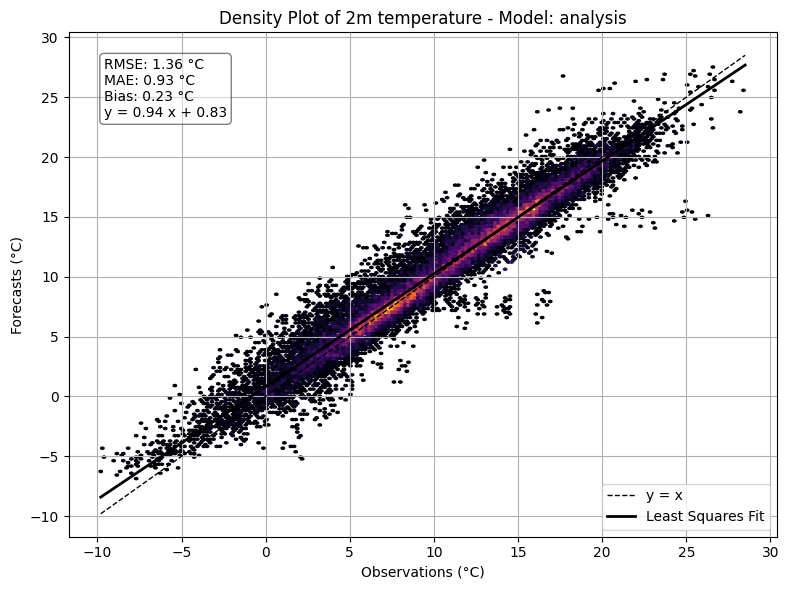

In [13]:
# take only the prediction_timedelta that are during the day
prediction_timedelta_day = ['12 hours', '18 hours', '36 hours', '42 hours', '60 hours', '66 hours', '84 hours', '90 hours'] 

# take only the prediction_timedelta that are during the night
prediction_timedelta_night = ['6 hours', '24 hours', '30 hours', '48 hours', '54 hours', '72 hours', '78 hours', '96 hours'] 

print('Day')
create_density_plot(
results,
variable='2m_temperature',
models= ['hres', 'meso', 'gc', 'pangu', 'ens', 'analysis'],
prediction_timedelta=prediction_timedelta_day,
)

print('Night')
create_density_plot(
results,
variable='2m_temperature',
models= ['hres', 'meso', 'gc', 'pangu', 'ens', 'analysis'],
prediction_timedelta=prediction_timedelta_night,
)

In [63]:
results = xr.open_dataset('/home/koenr/thesis_code/results_2022_ws_gcshifted_mesohourly15pdt_gc_pangu_ERA5_ens_rain_wd.nc')

# Variables to consider
variables = [
    '2m_temperature',
    'mean_sea_level_pressure',
    '10m_wind_speed',
    '10m_v_component_of_wind',
    '10m_u_component_of_wind',
    'total_precipitation_6hr'
]

# Initialize a dictionary to store the NaN counts
nan_counts_dict = {model: {} for model in model_suffixes}

# Loop through each variable and model to calculate NaN counts
for variable in variables:
    for model in model_suffixes:
        model_var_name = f"{variable}_{model}"
        if model_var_name not in results:
            print(f"Model variable '{model_var_name}' not found in dataset. Skipping model '{model}'.")
            continue
        model_data = results[model_var_name]

        # Compute the NaN count and store it in the dictionary
        nan_count = model_data.isnull().sum().item()  # Convert the result to a scalar
        nan_counts_dict[model][variable] = nan_count

# Convert the dictionary to a DataFrame
nan_counts_df = pd.DataFrame.from_dict(nan_counts_dict, orient='index')

# add a total column
nan_counts_df['Total'] = nan_counts_df.sum(axis=1)

# sort the models by the total number of NaN values
nan_counts_df = nan_counts_df.sort_values(by='Total', ascending=False)

# Display the DataFrame
display(nan_counts_df)

# write to csv
nan_counts_df.to_csv('nan_counts.csv')

,2m_temperature,mean_sea_level_pressure,10m_wind_speed,10m_v_component_of_wind,10m_u_component_of_wind,total_precipitation_6hr,Total
analysis,0,0,0,0,0,266208,266208
pangu,0,0,0,0,0,266208,266208
gc,29328,29328,29328,29328,29328,29328,175968
meso,16638,16638,16638,16638,16638,16638,99828
pangu_gc_ens,0,0,0,0,0,29328,29328
meso_pangu_ens,0,0,0,0,0,16638,16638
meso_gc_ens,846,846,846,846,846,846,5076
hres,0,0,0,0,0,0,0
hres_pangu_ens,0,0,0,0,0,0,0
meso_hres_ens,0,0,0,0,0,0,0
